In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from fastai import *
from fastai.vision import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch

In [3]:
Path = '../input/gala-dataset/dataset/'

In [4]:
train_df = pd.read_csv(Path+'train.csv')
test_df = pd.read_csv(Path+'test.csv')

In [5]:
train_df.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [6]:
# from sklearn.preprocessing import LabelEncoder
# lb = LabelEncoder()
# train_df['Class'] = lb.fit_transform(train_df['Class'])

In [7]:
test_df.head()

,Image
0,image6245.jpg
1,image10409.jpg
2,image8692.jpg
3,image10517.jpg
4,image2580.jpg


In [8]:
# d = {0:'Attire', 1:'Decorationandsignage', 2:'Food', 3:'misc'}

In [9]:
bs = 32
SIZE = 240

tfms = get_transforms(do_flip=True,flip_vert=True,max_warp=0.,max_rotate=360.0)

In [10]:
test_data = (ImageList.from_df(df=test_df,folder='Test Images',path=Path))

train_data = (ImageList.from_df(df=train_df,folder='Train Images',path=Path)
       .split_by_rand_pct(0.1)
       .label_from_df(cols='Class')
       .transform(tfms,size=SIZE)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [11]:
train_data

ImageDataBunch;

Train: LabelList (5385 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
Food,misc,Attire,Food,Attire
Path: ../input/gala-dataset/dataset;

Valid: LabelList (598 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
Food,Attire,Attire,Attire,Food
Path: ../input/gala-dataset/dataset;

Test: None

In [12]:
test_data

ImageList (3219 items)
Image (3, 80, 80),Image (3, 53, 80),Image (3, 80, 80),Image (3, 60, 80),Image (3, 59, 80)
Path: ../input/gala-dataset/dataset

In [13]:
train_data.add_test(test_data)

In [14]:
train_data

ImageDataBunch;

Train: LabelList (5385 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
Food,misc,Attire,Food,Attire
Path: ../input/gala-dataset/dataset;

Valid: LabelList (598 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
Food,Attire,Attire,Attire,Food
Path: ../input/gala-dataset/dataset;

Test: LabelList (3219 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: EmptyLabelList
,,,,
Path: ../input/gala-dataset/dataset

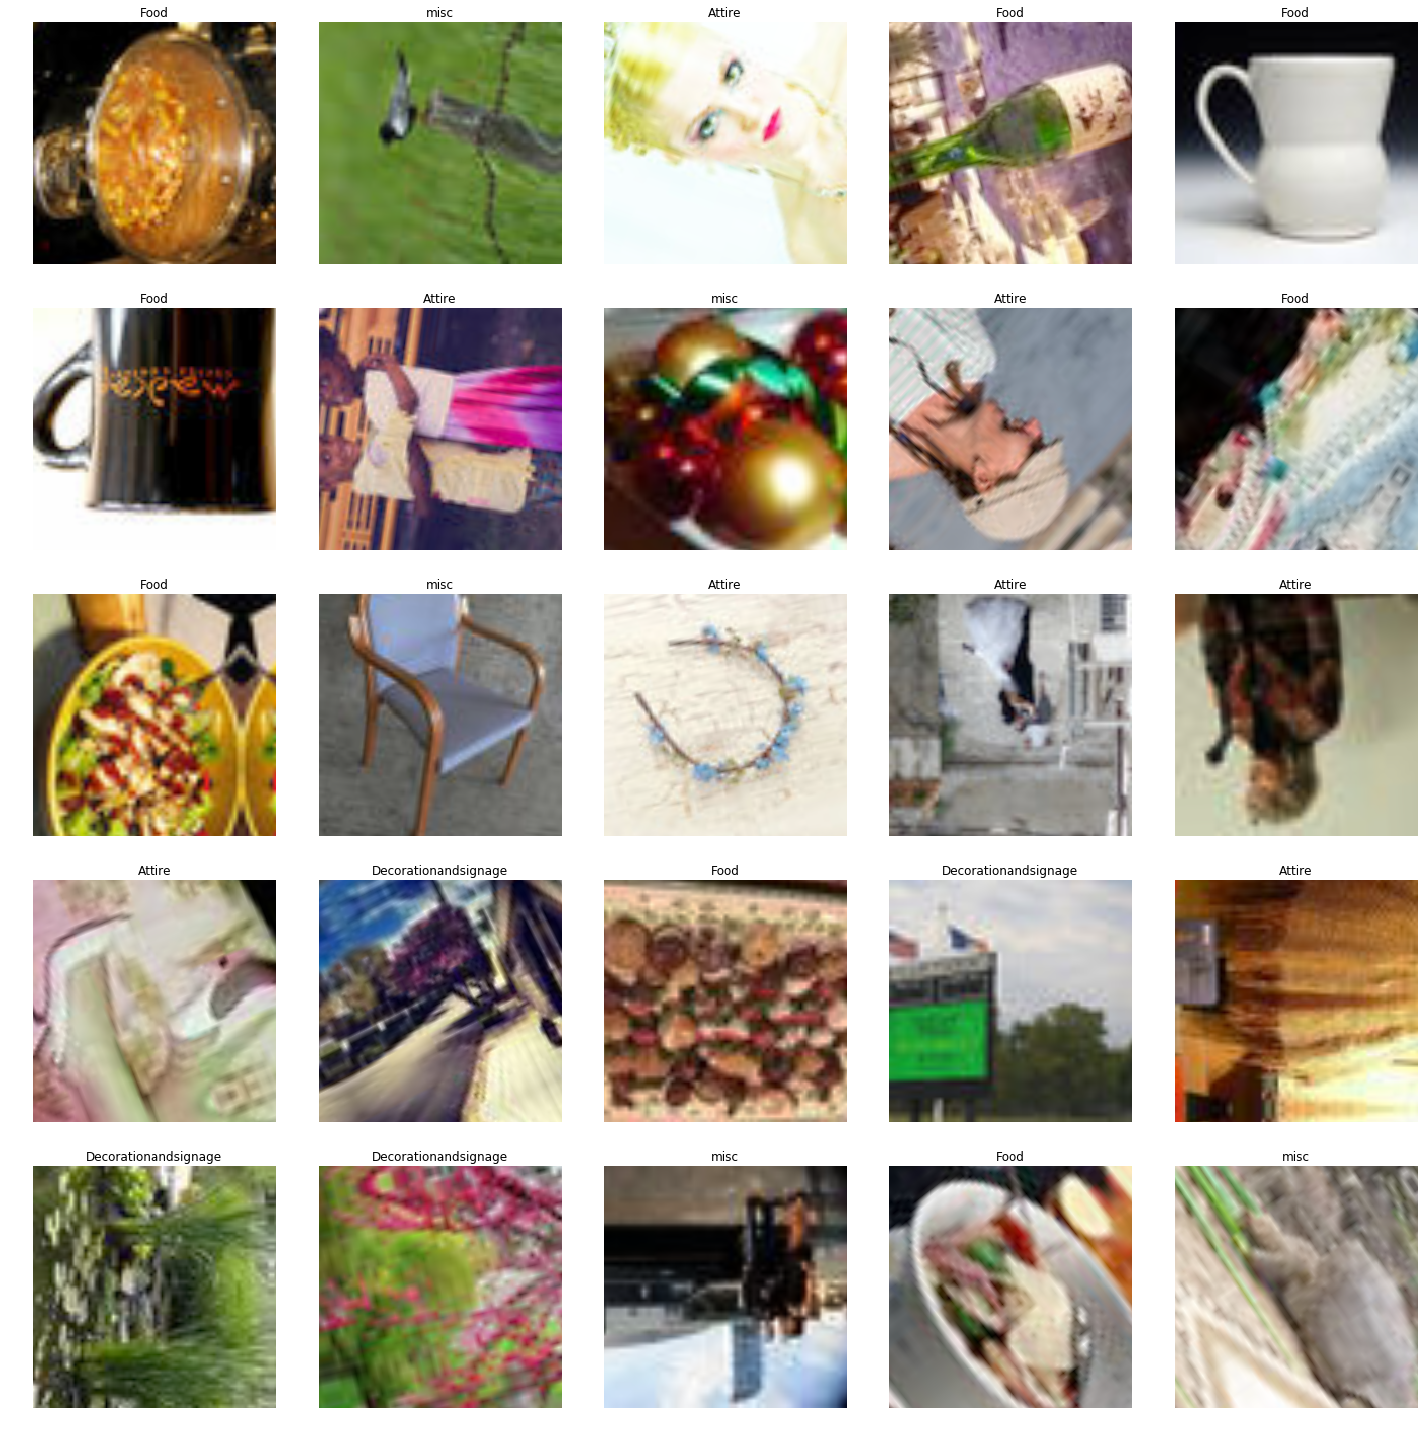

In [15]:
train_data.show_batch(rows=5,fig_size=(5,5))

In [16]:
arch = models.resnet50

In [17]:
# acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(F1, thresh=0.2, average='weighted')
from fastai.metrics import FBeta

In [18]:
learn = cnn_learner(train_data, arch, metrics=[FBeta(average='weighted')],pretrained=True,path='../working/')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [19]:
learn.lr_find()

epoch,train_loss,valid_loss,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.51E-04


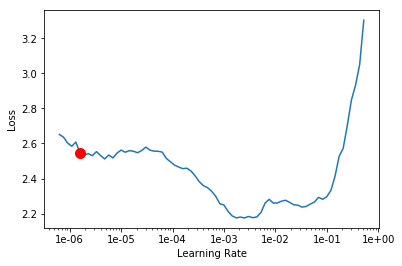

In [20]:
learn.recorder.plot(suggestion=True)

In [21]:
learn.fit_one_cycle(12, 1e-03)

epoch,train_loss,valid_loss,f_beta,time
0,1.603901,0.839366,0.715336,00:46
1,1.364663,0.803535,0.743272,00:43
2,1.088842,0.602564,0.782744,00:43
3,0.920062,0.578469,0.788051,00:44
4,0.784366,0.569959,0.784912,00:44
5,0.714974,0.498455,0.819420,00:44
6,0.634577,0.500136,0.809976,00:43
7,0.611955,0.496080,0.820608,00:44
8,0.565980,0.471593,0.814478,00:44
9,0.512003,0.465791,0.836835,00:44


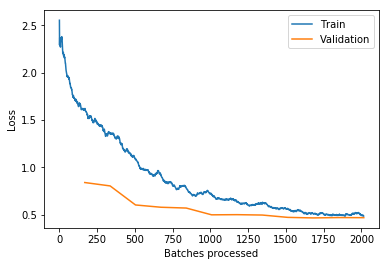

In [22]:
learn.recorder.plot_losses()

In [23]:
learn.save('model-stage1')

In [24]:
preds, y = learn.get_preds(DatasetType.Test)

In [25]:
test_df['Class'] = 0
test_df.head()

,Image,Class
0,image6245.jpg,0
1,image10409.jpg,0
2,image8692.jpg,0
3,image10517.jpg,0
4,image2580.jpg,0


In [26]:
sample_df = test_df.copy()
sample_df['Class'] = preds.argmax(1)

In [27]:
sample_df.head(20)

,Image,Class
0,image6245.jpg,2
1,image10409.jpg,2
2,image8692.jpg,2
3,image10517.jpg,2
4,image2580.jpg,0
5,image848.jpg,0
6,image1232.jpg,0
7,image8386.jpg,0
8,image9828.jpg,3
9,image9033.jpg,0


In [28]:
d = {0:'Attire', 1:'Decorationandsignage', 2:'Food', 3:'misc'}

In [29]:
sample_df.replace({"Class":d}, inplace=True)
sample_df.head()

,Image,Class
0,image6245.jpg,Food
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire


In [30]:
sample_df.to_csv('submission.csv', index=False)